(ac_opf:title)=
# Conic Relaxation of Optimal AC Power Flows

## Exact AC Power Flow Formulation and System Parameters
The optimal power flow (OPF) stands as a fundamental optimization problem in the analysis of electrical power systems. It is typically a large scale non-convex optimization problem, where thousands of generators, loads, and transmission lines are considered, and is required to be solved in every few minutes. In this document, we will solve the modified AC OPF model introduced in {cite:ps}`Kocuk_Dey_Sun_2016strong`,

```{math}
\begin{align}
\min~&\sum\limits_{k\in\mathcal{K}} c_kp_k \label{obj}\tag{1} \\
\text{s.t.}~&P_k^{\min} \leq p_k \leq P_k^{\max}, Q_k^{\min} \leq q_k \leq Q_k^{\max} &\forall k \in \mathcal{G} \label{power_capacity}\tag{2}\\
&\sum\limits_{k\in\beta(i)}p_k - P_i = G_{ii}u_{ii} + \sum\limits_{j\in\delta(i)}\left(G_{ij}u_{ij} - B_{ij}v_{ij}\right)&\forall i \in \mathcal{B} \label{power_balance_real} \tag{3}\\
&\sum\limits_{k\in\beta(i)}q_k - Q_i = -B_{ii}u_{ii} + \sum\limits_{j\in\delta(i)}\left(-B_{ij}u_{ij} - G_{ij}v_{ij}\right) &\forall i \in \mathcal{B} \label{power_balance_imaginary} \tag{4}\\
&\left({V}_i^{\min}\right)^2 \leq u_{ii} \leq \left({V}_i^{\max}\right)^2 &\forall i \in \mathcal{B} \label{voltage_limits} \tag{5}\\
&u_{ij}\tan(\theta_{\min})\leq v_{ij} \leq u_{ij}\tan(\theta_{\max}) &\forall (i, j) \in \mathcal{L} \label{angle_limits} \tag{6}\\
&\left(G_{ij}u_{ii} + G_{ij}u_{ij} - B_{ij}v_{ij}\right)^2 + \left(B_{ij}u_{ii} -B_{ij}u_{ij} - G_{ij}\right)^2 \leq T_{ij}^{\max} &\forall (i, j) \in \mathcal{L} \label{line_thermal_limits} \tag{7}\\
&u_{ij} = u_{ji}, v_{ij} = -v_{ji} &\forall (i, j) \in \mathcal{L} \label{nonlinearity} \tag{8}\\
&u_{ij}^2 + v_{ij}^2 = u_{ii}u_{jj} &\forall (i, j) \in \mathcal{L} \label{nonconvexity} \tag{9}
\end{align}
```

where the decision variables are

- $\pmb{p}$: the real power generation output of each generator; 
- $\pmb{q}$: the real power generation output of each generator; 
- $\pmb{u}$, $\pmb{v}$: the intermediate variables capturing the nonlinearity of power flows,

with the sets

- $\mathcal{B}$: the set of all bus indexes;
- $\mathcal{G}$: the set of all generator indexes;
- $\mathcal{L}$: the set of transmission lines in terms of the from-bus $i$ and to-bus $j$,

parameters

- $\pmb{c}$: cost coefficients of generators;
- $\pmb{P}^{\min}$, $\pmb{P}^{\max}$: the lower/upper bound of real power generation of each generator;
- $\pmb{Q}^{\min}$, $\pmb{Q}^{\max}$: the lower/upper bounds of reactive power generation of each generator;
- $\pmb{G}$: a two-dimensional array representing the real components of the nodal admittance matrix;
- $\pmb{B}$: a two-dimensional array representing the imaginary components of the nodal admittance matrix;
- $\pmb{V}^{\min}$, $\pmb{V}^{\max}$: the lower/upper bound of voltage magnitude at each bus;
- $\pmb{P}$: the demand of real power generation at each bus;
- $\pmb{Q}$: the demand of reactive power generation at each bus.
- $\pmb{\theta}^{\min}$, $\pmb{\theta}^{\max}$: the lower/upper bounds of voltage angle difference in each transmission line;
- $\pmb{T}^{\max}$: the power capacity of each transmission line,

and functions:
- $\beta(i)$: the indexes of generators placed at bus $i$;
- $\delta(i)$: the indexes of buses connected to bus $i$.

Here, we use the [IEEE 39-Bus System](ieee_case39.xlsx) as an example, the system sets, parameters, and relevant functions are created using the following code segment.

In [1]:
import pandas as pd
import numpy as np

bus = pd.read_excel('ieee_case39.xlsx', sheet_name='bus')
gen = pd.read_excel('ieee_case39.xlsx', sheet_name='gen')
branch = pd.read_excel('ieee_case39.xlsx', sheet_name='branch')

baseMVA = 100

# Sets
Bset = bus.index
Gset = gen.index
branch_ij = branch.set_index(['fbus', 'tbus'])
Lset = branch_ij.index

# Parameters
G = pd.read_excel('ieee_case39.xlsx', sheet_name='G').values 
B = pd.read_excel('ieee_case39.xlsx', sheet_name='B').values
Vmin, Vmax = bus['Vmin'].values, bus['Vmax'].values
P = bus['Pd'].values / baseMVA
Q = bus['Qd'].values / baseMVA
c = gen['Cost'].values
Pmin, Pmax = gen['Pmin'].values / baseMVA, gen['Pmax'].values / baseMVA
Qmin, Qmax = gen['Qmin'].values / baseMVA, gen['Qmax'].values / baseMVA
θmax = branch_ij['angmax'] * np.pi / 180
θmin = branch_ij['angmin'] * np.pi / 180
Tmax = branch_ij['rateA'] / baseMVA

# Function
β = lambda i: gen.index[gen['bus'] == i].tolist()
δ = lambda i: list(branch.loc[branch['fbus'] == i, 'tbus']) + list(branch.loc[branch['tbus'] == i, 'fbus'])

The formulation above minimizes the total cost of generating real power, expressed by the objective function $(1)$, subject to
- Power capacity constraints $(2)$;
- Power balance equations $(3)$ and $(4)$;
- Voltage magnitude limits $(5)$;
- Voltage angle limits $(6)$;
- Transmission line thermal limits $(7)$;
- Constraints $(8)$ and $(9)$ capturing the nonlinearity of AC power flows.

Notice that the last constraint (9) is non-convex so it will be approximated by two relaxation methods described below.

## SOCP Relaxation

The first approximation method introduced by {cite:ps}`Jabr2006radial` is to relax the equality constraint (9) as the following inequalities

```{math}
u_{ij}^2 + v_{ij}^2 \leq u_{ii}u_{jj} ~~~~~\forall (i, j) \in \mathcal{L},
```

which are rotated second-order cone in $\mathbb{R}^4$, thus the AC power flow model can be solved as the second-order cone programming (SOCP) problem below.

In [2]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

model = ro.Model()

p = model.dvar(len(Gset))
q = model.dvar(len(Gset))
NB = len(Bset)
u = model.dvar((NB, NB))
v = model.dvar((NB, NB))

model.min(c@(p*baseMVA))                                                                         # (1)

model.st(Pmin <= p, p <= Pmax, Qmin <= q, q <= Qmax)                                             # (2)

for i in Bset:
    k, j = β(i), δ(i)
    model.st(sum(p[k]) - P[i] == G[i, i]*u[i, i] + sum(G[i, j]*u[i, j] - B[i, j]*v[i, j]))       # (3)
    model.st(sum(q[k]) - Q[i] == -B[i, i]*u[i, i] + sum(-B[i, j]*u[i, j] - G[i, j]*v[i, j]))     # (4)
    model.st(Vmin[i]**2 <= u[i, i], u[i, i] <= Vmax[i]**2)                                       # (5)
    
for i, j in Lset:
    model.st(v[i, j] >= np.tan(θmin[i, j])*u[i, j], v[i, j] <= np.tan(θmax[i, j])*u[i, j])       # (6)
    model.st(rso.sumsqr(-G[i, j]*u[i, i] + G[i, j]*u[i, j] - B[i, j]*v[i, j],
                        B[i, j]*u[i, i] - B[i, j]*u[i, j] - G[i, j]*v[i, j]) <= Tmax[i, j]**2)   # (7)
    model.st(u[i, j] == u[j, i], v[i, j] == -v[j, i])                                            # (8)
    model.st(rso.rsocone(rso.vec(u[i, j], v[i, j]), u[i, i], u[j, j]))                           # (9)
    
model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 0.0472s


After solving the SOCP problem using Mosek, the real and reactive power outputs are saved as variables `p_socp` and `q_scop`, respectively, and the objective value is printed by the following code cell.

In [3]:
p_socp = p.get()
q_socp = q.get()
print(model.get())

137435.49135999446


## SDP Relaxation

Alternatively, the non-convex constraints (9) can be relaxed as semidefinite cones, as proposed by {cite:ps}`Bai_Wei_Fujisawa_Wang_2008semidefinite`. To capture the nonlinearity of power flows, a positive semidefinite matrix $W\in\mathbb{S}_+^{2|\mathcal{G}|\times 2|\mathcal{G}|}$ is introduced such that:

$$
\begin{align}
&u_{ij} = W_{ij} + W_{i'j'} & \forall i\in\mathcal{B}, \forall j\in\mathcal{B} \\
&v_{ij} = W_{ij'} - W_{ji'} & \forall i\in\mathcal{B}, \forall j\in\mathcal{B}
\end{align}
$$

where $i'=i+|\mathcal{B}|$ and $j'=j+|\mathcal{B}|$. The AC power flow model is hence solved as the following semidefinite programming (SDP) problem.

In [4]:
from rsome import ro
from rsome import msk_solver as msk
import rsome as rso

model = ro.Model()

p = model.dvar(len(Gset))
q = model.dvar(len(Gset))
NB = len(Bset)
W = model.dvar((2*NB, 2*NB))

model.min(c@(p*baseMVA))                                                                         # (1)

model.st(Pmin <= p, p <= Pmax, Qmin <= q, q <= Qmax)                                             # (2)

for i in Bset:
    k, j = β(i), δ(i)
    
    ip, jp = i + NB, np.array(j) + NB
    uii = W[i, i] + W[ip, ip]
    uij = W[i, j] + W[ip, jp]
    vij = W[i, jp] - W[j, ip]
    
    model.st(sum(p[k]) - P[i] == G[i, i]*uii + sum(G[i, j]*uij - B[i, j]*vij))                   # (3)
    model.st(sum(q[k]) - Q[i] == -B[i, i]*uii + sum(-B[i, j]*uij - G[i, j]*vij))                 # (4)
    model.st(Vmin[i]**2 <= uii, uii <= Vmax[i]**2)                                               # (5)
    
for i, j in Lset:
    ip, jp = i + NB, j + NB
    uii = W[i, i] + W[ip, ip]
    uij = W[i, j] + W[ip, jp]
    vij = W[i, jp] - W[j, ip]
    
    model.st(vij >= np.tan(θmin[i, j])*uij, vij <= np.tan(θmax[i, j])*uij)                       # (6)
    model.st(rso.sumsqr(-G[i, j]*uii + G[i, j]*uij - B[i, j]*vij,
                        B[i, j]*uii - B[i, j]*uij - G[i, j]*vij) <= Tmax[i, j]**2)               # (7)

model.st(W >> 0)

model.solve(msk)

Being solved by Mosek...
Solution status: Optimal
Running time: 2.7502s


Similar to the SOCP relaxation, we save the optimal real and reactive power outputs as `p_sdp` and `q_sdp`, respectively, and print the objective value as below.

In [5]:
p_sdp = p.get()
q_sdp = q.get()
print(model.get())

138257.6888818642


## Visualization of Optimal Generation Outputs

In this section, we visualize the real and reactive power outputs to compare the solutions of the SOCP and SDP relaxation methods.

In [6]:
ps = pd.DataFrame({'SOCP': p_socp, 'SDP': p_sdp})
qs = pd.DataFrame({'SOCP': q_socp, 'SDP': q_sdp})

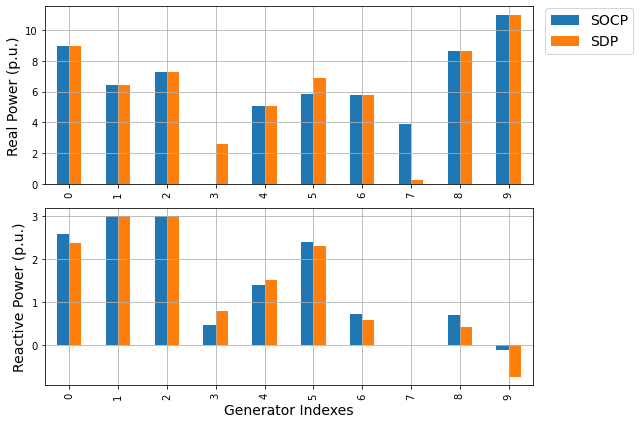

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(9, 6))

ps.plot(kind='bar', ax=axes[0])
qs.plot(kind='bar', ax=axes[1], legend=False)
axes[1].set_xlabel('Generator Indexes', fontsize=14)
axes[0].set_ylabel('Real Power (p.u.)', fontsize=14)
axes[1].set_ylabel('Reactive Power (p.u.)', fontsize=14)
axes[0].legend(fontsize=14, bbox_to_anchor=(1.01, 1.03))
axes[0].grid()
axes[1].grid()
plt.tight_layout()
plt.show()

<br>

---

<font size="5">Reference</font>

```{bibliography}
:filter: docname in docnames
```